Linear models are amazingly powerful, but also have limitations.  For example, their ranges (potential outputs for your y/response variable) are potentially infinite.  This means, given some imputs, it is possible to get arbitrarily large outputs, or arbitrarily small (i.e., negative) outputs.  

There are many cases when this is undesirable.  
- What if you are trying to predict counts of something?  Then negative values make no sense.  
- What if you are trying to predict the proportion of something?  Then only values on [0, 1] make sense.
- What if you are trying to predict categorical values?  How do you do this with numerical inputs?

These are some of the problems that generalized linear models (GLMs) address.  

In very broad terms, GLMs work by transforming the response variable in a nonlinear way such that the transformed response fits the range constraints of the problem.  

### Predicting Proportions
Data here are fictitious, but mimic a "capture-recapture" process used by wildlife biologists to estimate animal populations.

In [35]:
make.data <- function(n, noise.level=0.1, rainfall.multiplier=1, seed) {
  set.seed(seed)
  area <- rpois(n, lambda=3)
  latitude <- runif(n, 0, 80)
  slope <- rnorm(n, 15, 10)
  slope[slope < 0 ] <- 0
  slope[slope > 60] <- 60
  rainfall <- rainfall.multiplier * rchisq(n, df=3)
  prop <- 0.6 - 0.2*area - 0.1*slope + 0.3*latitude - 3*rainfall
  rng <- max(prop) - min(prop)
  noise <- rnorm(n, 0, sd=noise.level*rng)
  prop <- prop + noise
  prop <- prop - min(prop)
  prop <- prop / max(prop)
  n <- 100
  recapture <- round(prop * n)
  uncaptured <- n - recapture
  data.frame(prop=prop,
             recapture=recapture,
             uncaptured=uncaptured,
             area=area, 
             latitude=latitude, 
             slope=slope, 
             rainfall=rainfall)
}

In [36]:
train <- make.data(500, seed=42)
head(train)

prop,recapture,uncaptured,area,latitude,slope,rainfall
0.2201323,22,78,5,10.920417,25.291407,9.3530655
0.5908628,59,41,6,14.170913,24.147749,3.1855964
0.4552964,46,54,2,41.564836,14.975437,4.4126285
0.6908706,69,31,5,64.889663,16.360096,2.8250013
0.6299122,63,37,3,9.228961,7.798465,0.5040749
0.7979529,80,20,3,71.473743,13.018757,0.3601050


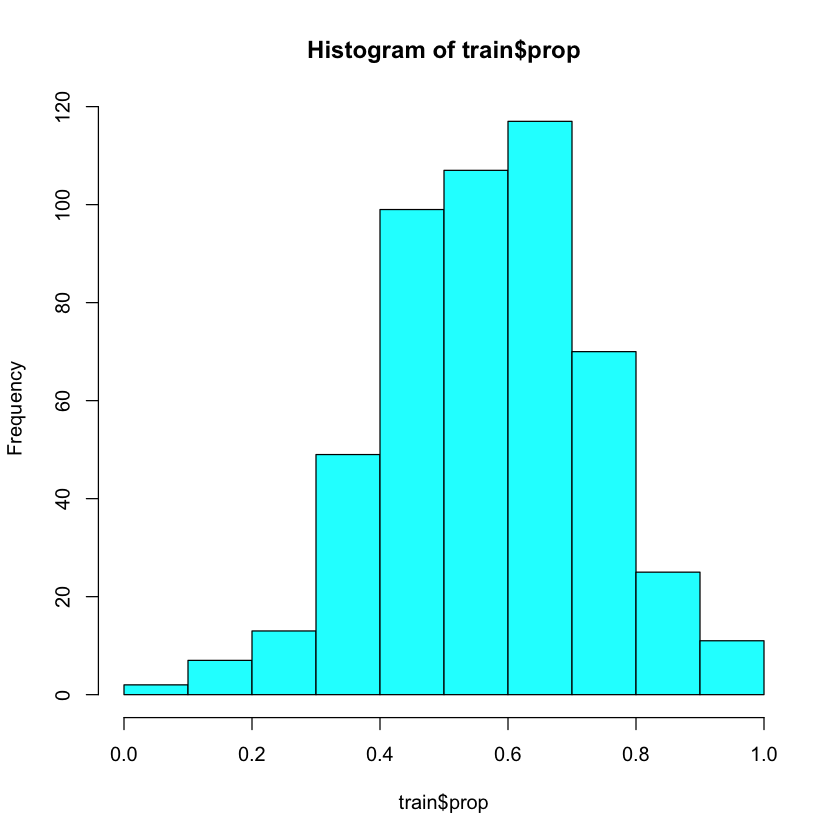

In [10]:
hist(train$prop, col=5)

### What happens when we use a simple linear model?

In [11]:
### Try it out
mod <- lm(prop ~ ., data=train)
summary(mod)


Call:
lm(formula = prop ~ ., data = train)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.224356 -0.049681 -0.002025  0.051470  0.270205 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.693e-01  1.118e-02  50.915  < 2e-16 ***
area        -3.641e-05  2.011e-03  -0.018    0.986    
latitude     4.218e-03  1.504e-04  28.050  < 2e-16 ***
slope       -1.739e-03  3.643e-04  -4.774 2.38e-06 ***
rainfall    -4.688e-02  1.568e-03 -29.892  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.07774 on 495 degrees of freedom
Multiple R-squared:  0.7685,	Adjusted R-squared:  0.7667 
F-statistic: 410.9 on 4 and 495 DF,  p-value: < 2.2e-16


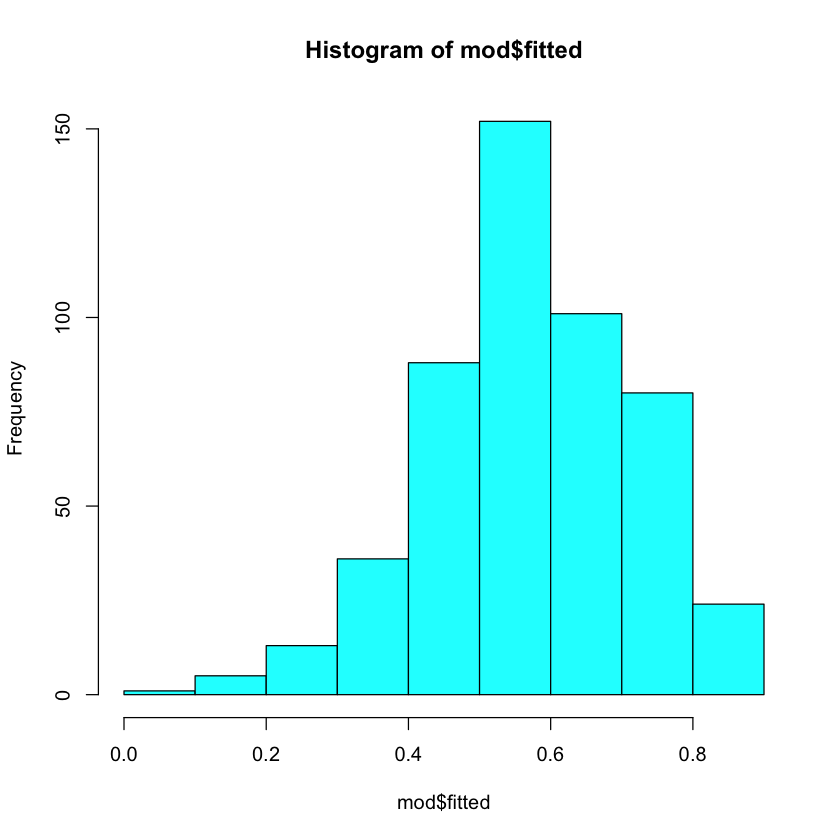

In [13]:
hist(mod$fitted, col=5)

Suppose we now try to predict on a region with much higher rainfall that anything we saw in our training set....

In [14]:
test.rain <- make.data(500, rainfall.multiplier=5, seed=77)
head(test.rain)

prop,area,latitude,slope,rainfall
0.6321716,2,70.76589,38.0046485,12.528308
0.5382827,4,63.14234,9.7844015,23.767580
0.7688967,5,74.03970,0.3605036,8.844299
0.7108935,6,30.80789,17.7872842,7.114922
0.5124002,4,66.03678,12.8124351,22.271623
0.7708028,3,40.79081,14.9405880,17.352608


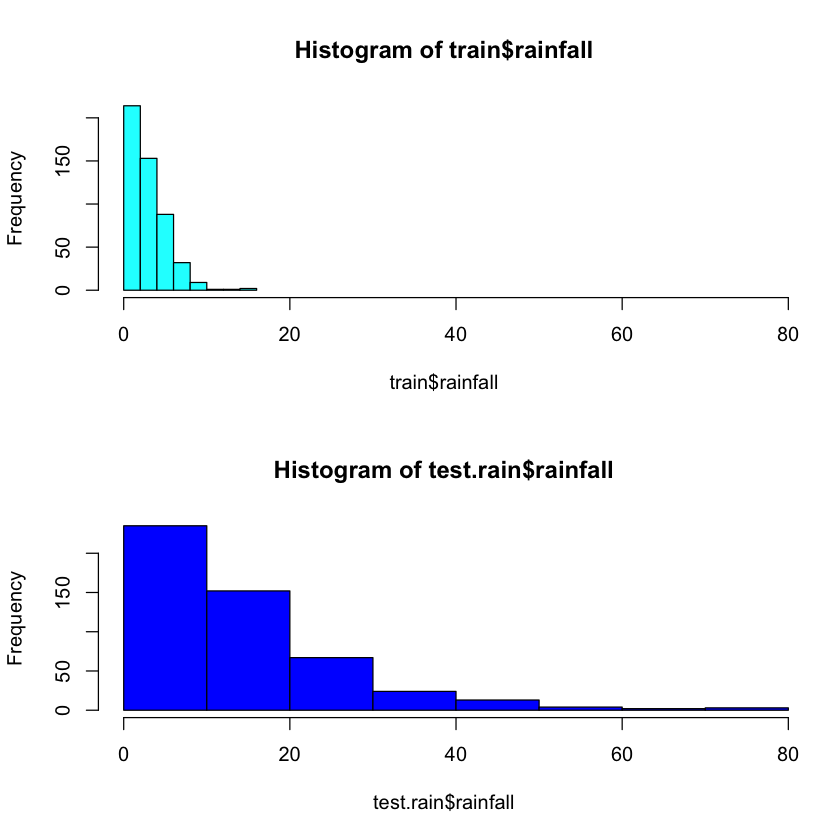

In [15]:
par(mfrow=c(2, 1))
lim <- range(c(train$rainfall, test.rain$rainfall))
hist(train$rainfall, col=5, xlim=lim)
hist(test.rain$rainfall, col=4, xlim=lim)

In [18]:
# How well does your model predict the new data set?
preds <- predict(mod, newdata=test.rain)

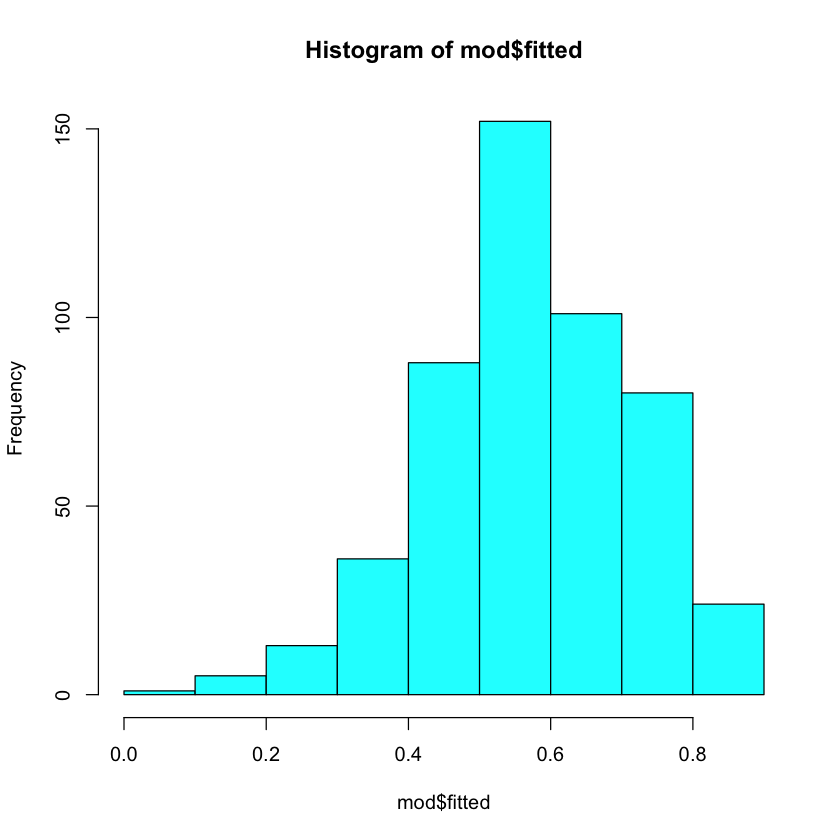

In [19]:
hist(mod$fitted, col=5)

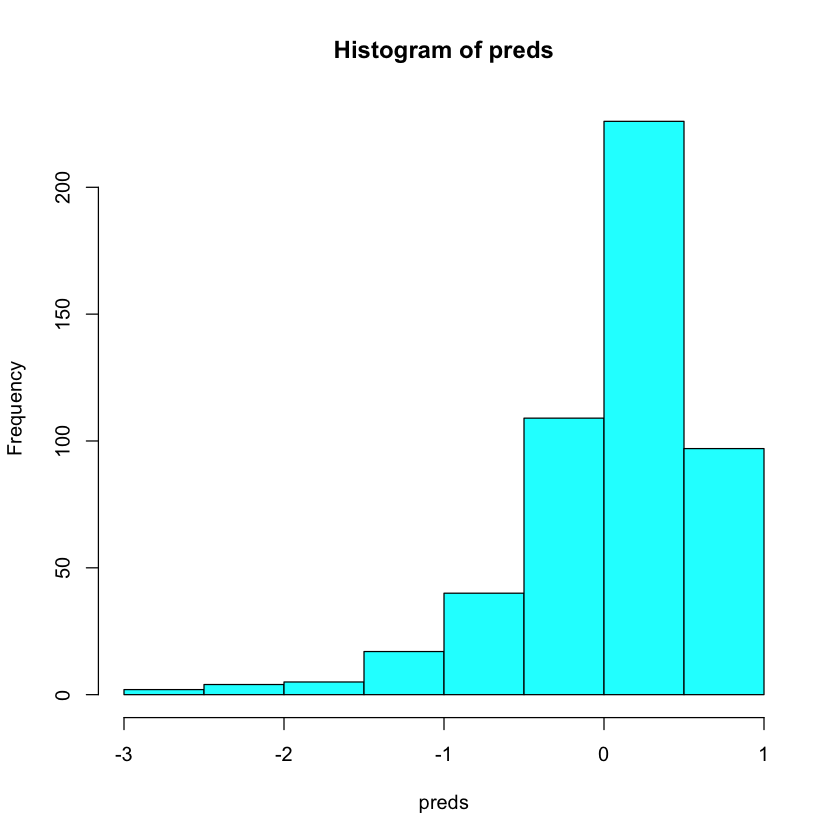

In [21]:
hist(preds, col=5)

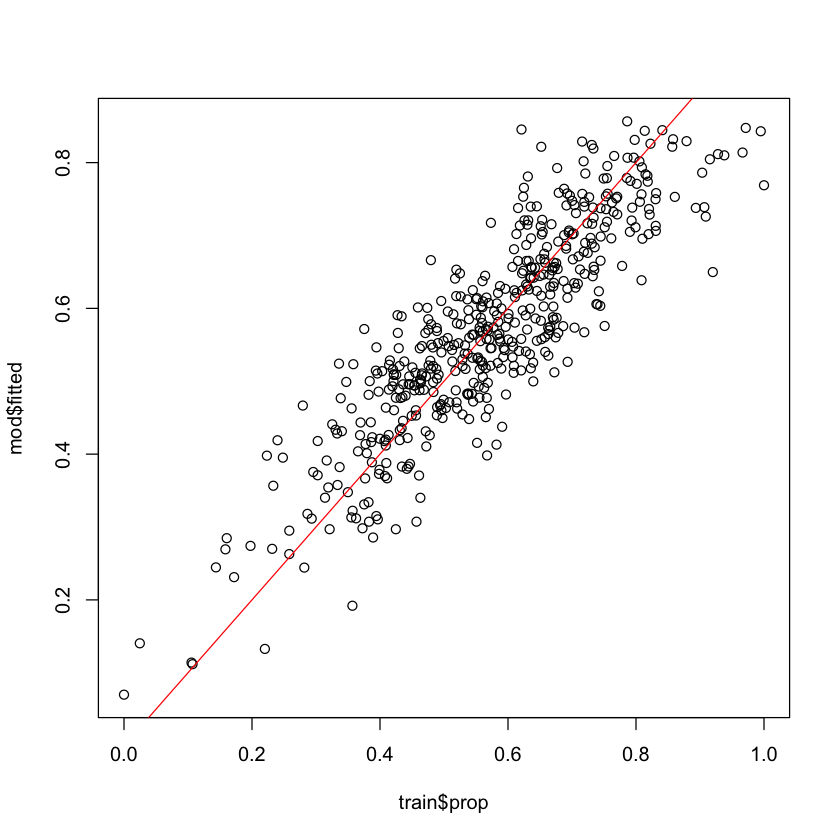

In [24]:
plot(train$prop, mod$fitted)
abline(0, 1, col=2)

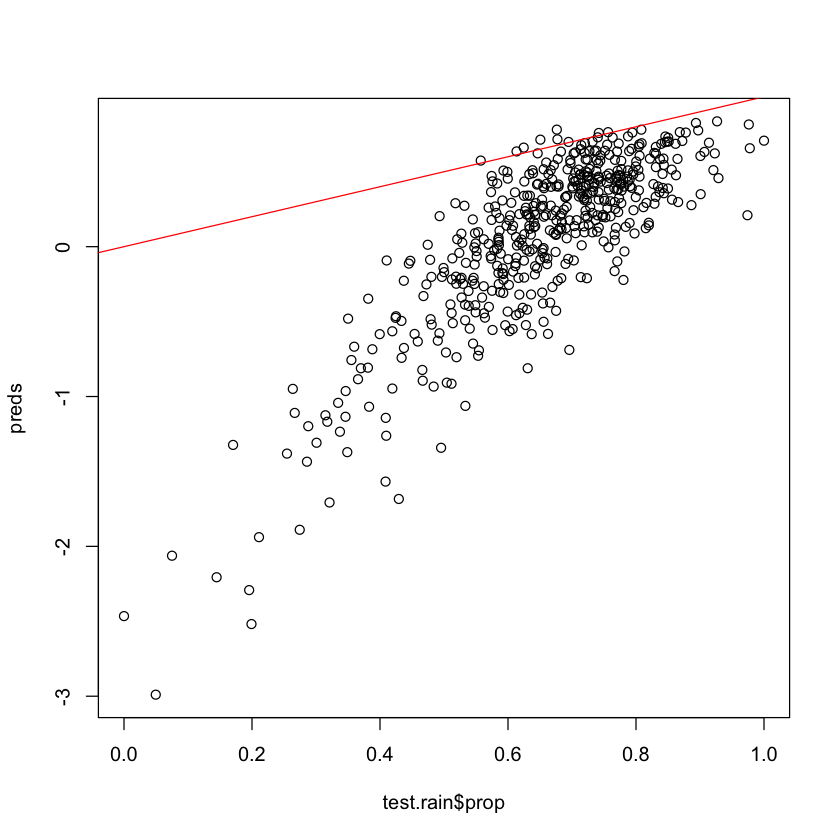

In [26]:
plot(test.rain$prop, preds)
abline(0, 1, col=2)

In [ ]:
# How might we improve this problem?

# The Logistic Function
https://en.wikipedia.org/wiki/Logistic_function

In [30]:
logistic <- function(x) {
  1 / (1 + exp(-x))
}

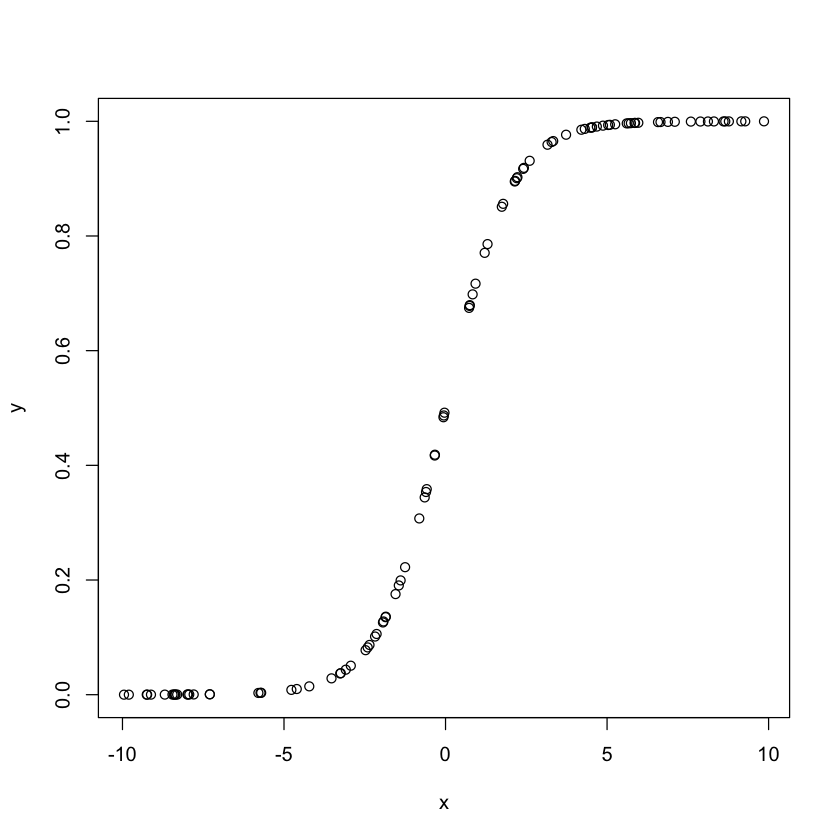

In [31]:
x <- runif(100, -10, 10)
y <- logistic(x)
plot(x, y)

In [37]:
head(train)

prop,recapture,uncaptured,area,latitude,slope,rainfall
0.2201323,22,78,5,10.920417,25.291407,9.3530655
0.5908628,59,41,6,14.170913,24.147749,3.1855964
0.4552964,46,54,2,41.564836,14.975437,4.4126285
0.6908706,69,31,5,64.889663,16.360096,2.8250013
0.6299122,63,37,3,9.228961,7.798465,0.5040749
0.7979529,80,20,3,71.473743,13.018757,0.3601050


In [39]:
gl.mod <- glm(c(recapture, uncaptured) ~ area + latitude + slope + rainfall, 
              data=train, 
              family=binomial)
summary(gl.mod)

ERROR: Error in model.frame.default(formula = c(recapture, uncaptured) ~ area + : variable lengths differ (found for 'area')


In [49]:
data(iris)

In [50]:
head(iris)

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa


In [51]:
unique(iris$Species)

[1] setosa     versicolor virginica 
Levels: setosa versicolor virginica

In [56]:
iris$Species <- 1 * (iris$Species == 'setosa')
head(iris)
dim(iris)

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.1,3.5,1.4,0.2,0
4.9,3.0,1.4,0.2,0
4.7,3.2,1.3,0.2,0
4.6,3.1,1.5,0.2,0
5.0,3.6,1.4,0.2,0
5.4,3.9,1.7,0.4,0


[1] 150   5

In [53]:
unique(iris$Species)

[1] 1 0

In [55]:
gl.mod <- glm(Species ~ ., data=iris, family=binomial)
summary(gl.mod)

Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Call:
glm(formula = Species ~ ., family = binomial, data = iris)

Deviance Residuals: 
       Min          1Q      Median          3Q         Max  
-3.185e-05  -2.100e-08  -2.100e-08   2.100e-08   3.173e-05  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)
(Intercept)     -16.946 457457.097       0        1
Sepal.Length     11.759 130504.042       0        1
Sepal.Width       7.842  59415.385       0        1
Petal.Length    -20.088 107724.594       0        1
Petal.Width     -21.608 154350.616       0        1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1.9095e+02  on 149  degrees of freedom
Residual deviance: 3.2940e-09  on 145  degrees of freedom
AIC: 10

Number of Fisher Scoring iterations: 25


In [57]:
gl.mod$fitted

1            2            3            4            5            6 
1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 
           7            8            9           10           11           12 
1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 
          13           14           15           16           17           18 
1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 
          19           20           21           22           23           24 
1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 
          25           26           27           28           29           30 
1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 
          31           32           33           34           35           36 
1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 
          37           38           39           40           41           42 
1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 
          43           44           45           46           47           48 
1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 
          49           50           51           52           53           54 
1.000000e+00 1.000000e+00 2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 
          55           56           57           58           59           60 
2.220446e-16 2.220446e-16 2.220446e-16 4.617163e-13 2.220446e-16 2.220446e-16 
          61           62           63           64           65           66 
2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 3.232718e-13 2.220446e-16 
          67           68           69           70           71           72 
2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 
          73           74           75           76           77           78 
2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 
          79           80           81           82           83           84 
2.220446e-16 4.855499e-10 2.220446e-16 1.733438e-13 2.220446e-16 2.220446e-16 
          85           86           87           88           89           90 
2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 
          91           92           93           94           95           96 
2.220446e-16 2.220446e-16 2.220446e-16 6.831500e-13 2.220446e-16 2.220446e-16 
          97           98           99          100          101          102 
2.220446e-16 2.220446e-16 5.071636e-10 2.220446e-16 2.220446e-16 2.220446e-16 
         103          104          105          106          107          108 
2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 
         109          110          111          112          113          114 
2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 
         115          116          117          118          119          120 
2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 
         121          122          123          124          125          126 
2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 
         127          128          129          130          131          132 
2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 
         133          134          135          136          137          138 
2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 
         139          140          141          142          143          144 
2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 
         145          146          147          148          149          150 
2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16